## Lo primero es importar todas las librearías que nos pueden servir

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import astropy.io.fits as fits
from mpdaf.obj import Cube
from mpdaf.obj import plot_rgb
from spectral_cube import SpectralCube

C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Primero cargamos uno de los cubos de MUSE como un Cube dentro de mpdaf

In [2]:
cube = Cube(filename="ngc5972.fits",ext=(1,2))

        Use textwrap.indent() instead. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 2768751990
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


# Ahora podemos obtener algo de información del cubo

C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mpdaf\tools\fits.py:220: RuntimeWarning: invalid value encountered in cast
  data = np.asarray(data, dtype=dtype)


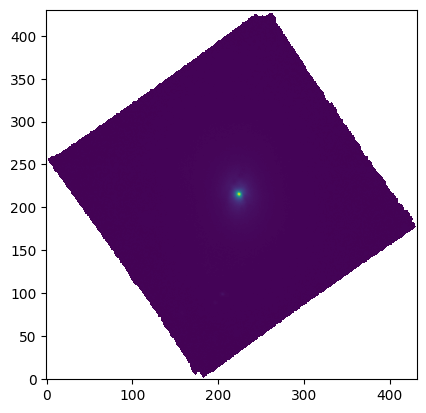

In [3]:
plt.imshow(cube[2000,:,:].data,origin='lower')


# Veamos como se ve un canal random y restar el continuo en todos los spaxel

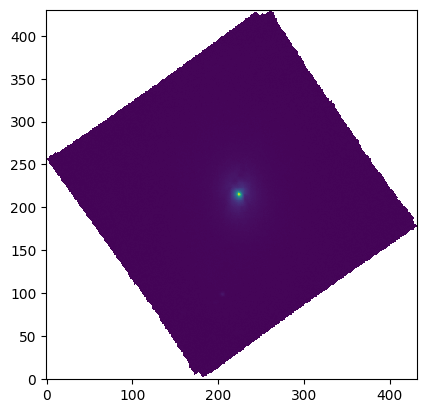

In [4]:
cube[1000,:,:].plot()

In [5]:

def eliminar_continuo(cube):
    for i in range(cube.shape[1]):
        for j in range(cube.shape[2]):
            pass

## NO CREO QUE HAGA ESTA PARTE
    

# Ahora hagamos un plot de un espectro de un spaxel central. 

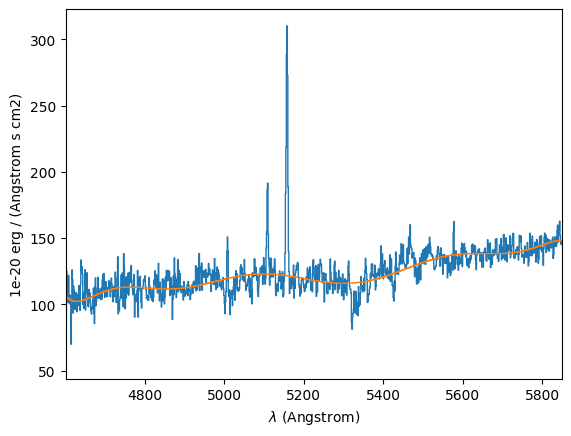

In [6]:
spc1 = cube[000:1000,223,214]
cont1 = spc1.poly_spec(10)
spc1.plot()
cont1.plot()

C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mpdaf\tools\fits.py:220: RuntimeWarning: invalid value encountered in cast
  data = np.asarray(data, dtype=dtype)


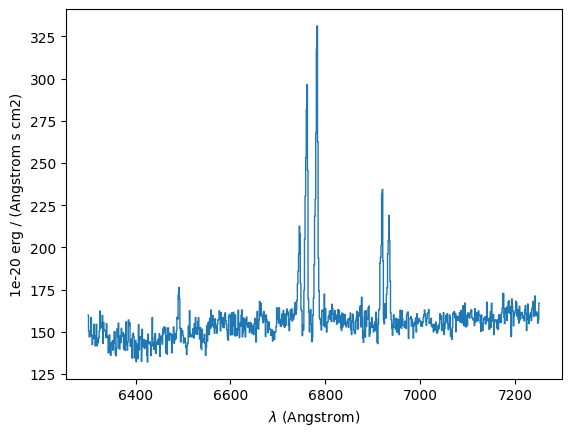

In [7]:
cube[:,223,214].plot(unit=u.angstrom,lmin=6300,lmax=7250)

C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mpdaf\tools\fits.py:220: RuntimeWarning: invalid value encountered in cast
  data = np.asarray(data, dtype=dtype)


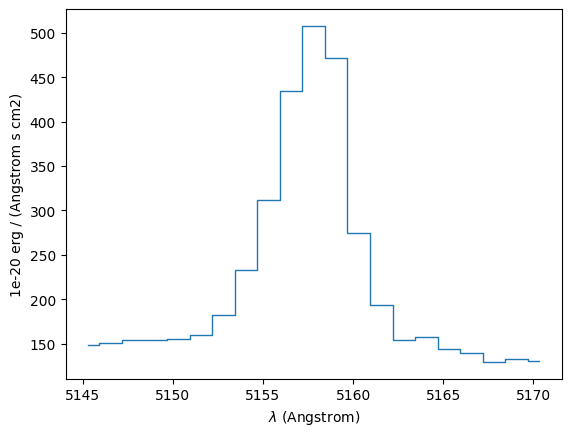

In [8]:
cube[:,223,216].plot(unit=u.angstrom,lmin=5155-10,lmax=5155+15)
# cube[:,150,160].plot(unit=u.angstrom,lmin=4600,lmax=5500)

# Podemos limitar el rango de longitud de onda y hacer un fit Gaussiano. 

C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mpdaf\tools\fits.py:220: RuntimeWarning: invalid value encountered in cast
  data = np.asarray(data, dtype=dtype)


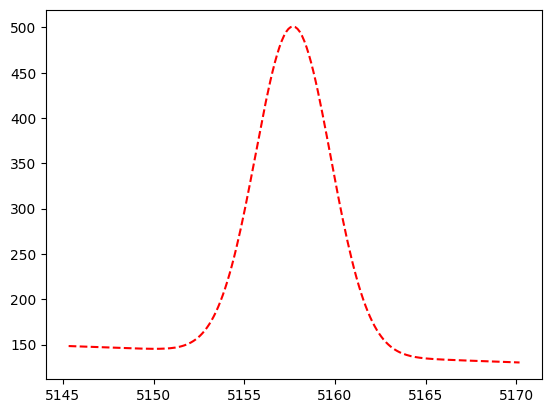

In [9]:
OIII = cube[:,223,216].gauss_fit(unit=u.angstrom,lmin=5155-10,lmax=5155+15, plot=True)

In [10]:
OIII.print_param()

[INFO] Gaussian center = 5157.7 (error:0.0774514)
[INFO] Gaussian integrated flux = 1876.8 (error:61.5192)
[INFO] Gaussian peak value = 361.624 (error:0.706152)
[INFO] Gaussian fwhm = 4.87561 (error:0.169337)
[INFO] Gaussian continuum = 139.314


# Ahora podemos hacer un imagen en colores de 3 rangos espectrales. 

C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mpdaf\tools\fits.py:220: RuntimeWarning: invalid value encountered in cast
  data = np.asarray(data, dtype=dtype)


(<Axes: >,
 [<Image(shape=(431, 432), unit='1e-20 erg / (Angstrom s cm2)', dtype='float64')>,
  <Image(shape=(431, 432), unit='1e-20 erg / (Angstrom s cm2)', dtype='float64')>,
  <Image(shape=(431, 432), unit='1e-20 erg / (Angstrom s cm2)', dtype='float64')>])

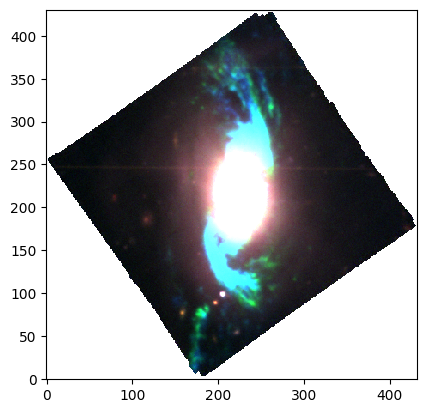

In [11]:
lines = {
    "OIII": (430, 455),
    "Hbeta": (315, 340),
    "NII": (1733, 1750),
    "Halpha": (1719, 1732)
}


plot_rgb([cube[430:455,:,:].sum(axis=0),cube[1719:1732,:,:].sum(axis=0),cube[2000:2100,:,:].sum(axis=0)],scale='linear',zscale=True)


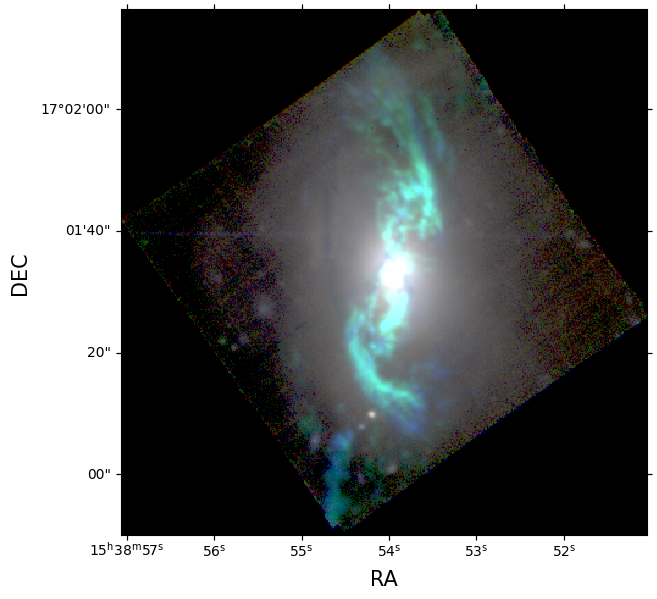

In [12]:
from mpdaf.obj import Cube, plot_rgb
import numpy as np

eps = 1e-10

def safe_log10(arr):
    # Enmascarar valores inválidos o <=0
    arr_ma = np.ma.masked_invalid(arr)
    arr_ma = np.ma.masked_less_equal(arr_ma, 0)
    
    # Normalizar
    arr_norm = arr_ma / arr_ma.max()
    
    # Aplicar gamma
    arr_gamma = arr_norm ** 0.28
    
    # Reemplazar NaN por 0 (negro)
    arr_gamma = np.ma.filled(arr_gamma, 0)
    return arr_gamma


OIII_img = cube[420:455,:,:].sum(axis=0)  # suma sobre λ
Halpha_img = cube[1719:1740,:,:].sum(axis=0)
#continuum_img = cube[2500:2510,:,:].sum(axis=0)
continuum_img = cube[150:300,:,:].sum(axis=0)


OIII_img.data = safe_log10(OIII_img.data)
Halpha_img.data = safe_log10(Halpha_img.data)
continuum_img.data = safe_log10(continuum_img.data)




plt.figure(figsize=(8, 6))
plot_rgb([ Halpha_img, OIII_img,continuum_img],
         scale='linear', zscale=True, use_wcs=True)
#plt.xlim(50,400)
#plt.ylim(50,400)
plt.tight_layout()
plt.xlabel("RA", fontsize = 15)
plt.ylabel("DEC", fontsize = 15)

plt.savefig("RGB NGC5972")


# Calculo de errores

## Funcion para calcular el scaling

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

def calculate_variance_scaling(cube, var_cube, wavelength_range=None):
    
    if wavelength_range is None:
        wavelength_range = (0, cube.shape[0])
    
    lmin, lmax = wavelength_range
    scaling_factors = []
    
    # Calcular para cada canal espectral en el rango
    for i in range(lmin, lmax):
        
        data_slice = cube[i, :, :].data
        var_slice = var_cube[i, :, :]
        # Aplicar máscara de cielo
        sky_data = data_slice
        sky_var = var_slice

        # Calcular RMS observado (ruido real)
        rms_observed = np.sqrt((sky_data**2).mean(axis=(0,1)))
        
        # Calcular RMS teórico (promedio de sqrt(varianza))
        rms_theoretical = np.sqrt(sky_var.mean(axis=(0,1)))
        
        if rms_theoretical > 0:
            scaling_factor = rms_observed / rms_theoretical
        else:
            scaling_factor = 1.0
            
        scaling_factors.append(scaling_factor)
    
    return np.array(scaling_factors)


## Funcion para crear la mask del cielo

In [14]:
import numpy as np

y_min, y_max = 208, 269  
x_min, x_max = 49, 115

cube_sky_region = cube[:, y_min:y_max, x_min:x_max] ## ESTO ES LO IMPORTANTE, YA EXTRAIMOS UNA PARTE DEL CIELO QUE PRESENTA ESTO.
print(np.sqrt(cube_sky_region[100,:,:].var.mean(axis=(0,1)))) # Teorico
print(np.sqrt((cube_sky_region[100,:,:].data**2).mean(axis=(0,1)))) # RMS
print(np.std(cube_sky_region[100,:,:].data)) # std

valores_de_escalamiento = calculate_variance_scaling(cube_sky_region, cube_sky_region.var)

C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mpdaf\tools\fits.py:220: RuntimeWarning: invalid value encountered in cast
  data = np.asarray(data, dtype=dtype)


3.3314358512474795
5.077942704689656
5.047725424481598


In [15]:
# Procedimiento final

for i in range(len(valores_de_escalamiento)):
    cube.var[i, :, :] = cube.var[i, :, :] * (valores_de_escalamiento[i] ** 2)

C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\mpdaf\tools\fits.py:220: RuntimeWarning: invalid value encountered in cast
  data = np.asarray(data, dtype=dtype)


# Bins de voronoi todo el procedimiento.

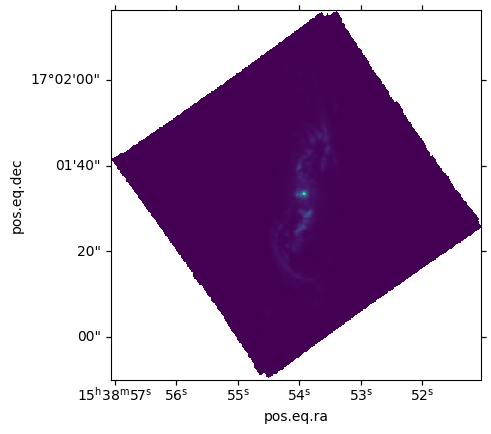

In [16]:
# Seleccionamos la de NII. FINALMENTE CAMBIE A Halpha
#1733:1750
cube[1733:1750,:,:].max(axis=0).plot(use_wcs=1) #NII
#cube[310:340,:,:].max(axis=0).plot() #Halha


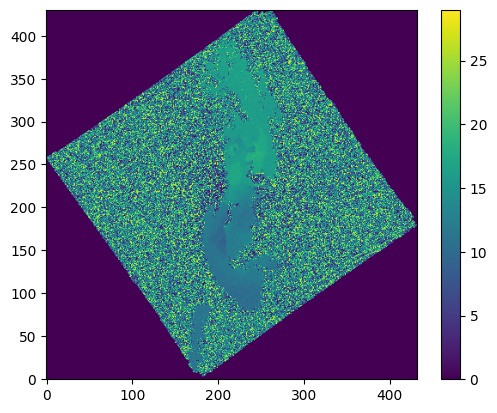

In [17]:
index_max = np.argmax(cube[310:340,:,:].data,axis=0) ## Para h_alpha
plt.imshow(index_max,origin='lower',cmap='viridis')
plt.colorbar()

In [18]:
## Calculo del profe, lo deje tal cual.

Error = np.sqrt(cube[310:340,:,:].var)
ErrorM8 = np.zeros_like(np.argmax(cube[310:340,:,:].data,axis=0))
ErrorM8 = ErrorM8.astype(float)
contador = 0
for i in range(len(index_max)):
    for j in range(len(index_max[i])):
        aux = index_max[i][j]
        if Error.mask[aux][i][j]:
            continue
        else:
            ErrorM8[i][j] = Error[aux][i][j]
print(contador,51*53)
ErrorM8 = ErrorM8.astype(float)
ErrorM8[ErrorM8==0] = np.nan

0 2703


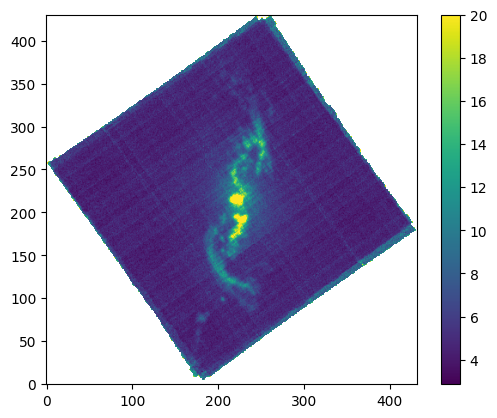

In [19]:
plt.imshow(ErrorM8,origin='lower',vmax=20)
plt.colorbar()

In [20]:
import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning


C:\Users\Maxlo\AppData\Local\Temp\ipykernel_34660\2687394452.py:2: UserWarning: ⚠️ VorBin is deprecated and superseded by PowerBin https://pypi.org/project/powerbin/ 
  from vorbin.voronoi_2d_binning import voronoi_2d_binning


In [21]:
signal = cube[310:340,:,:].max(axis=0).data
noise = ErrorM8
sn = signal/noise
x,y = np.nonzero(sn>5)

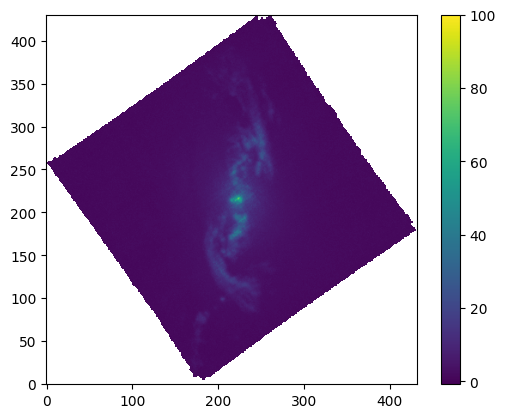

In [22]:
plt.imshow(sn,origin='lower',vmax=100)
plt.colorbar()

In [23]:
import numpy as np

# Parámetros del .wcs

CRPIX1, CRPIX2 = 222.500516265834, 212.384202311303
CRVAL1, CRVAL2 = 234.724892, 17.0257
CD11, CD12 = -5.55555555555556e-05, 0.0
CD21, CD22 = 0.0, 5.55555555555556e-05

def pix2deg_arrays(x_pix, y_pix):
    """
    Convierte arrays de píxeles (x_pix, y_pix) a RA y Dec en grados.
    """
    x_arr = np.array(x_pix)
    y_arr = np.array(y_pix)
    
    # Desplazamiento respecto al píxel de referencia
    delta_x = x_arr - CRPIX1
    delta_y = y_arr - CRPIX2
    
    # Transformación usando la matriz CD
    ra_deg  = CRVAL1 + CD11 * delta_x + CD12 * delta_y
    dec_deg = CRVAL2 + CD21 * delta_x + CD22 * delta_y
    
    return ra_deg, dec_deg


ra, dec = pix2deg_arrays(x, y)


def deg2arcsec(ra_deg, dec_deg):
    ra_arcsec  = ra_deg * 3600
    dec_arcsec = dec_deg * 3600
    return ra_arcsec, dec_arcsec

ra_arcsec, dec_arcsec = deg2arcsec(ra, dec)


ra0, dec0 = CRVAL1, CRVAL2  # centro en grados
ra0_arcsec, dec0_arcsec = deg2arcsec(np.array([ra0]), np.array([dec0]))

delta_ra_arcsec  = ra_arcsec  - ra0_arcsec
delta_dec_arcsec = dec_arcsec - dec0_arcsec

# Ahora delta_ra_arcsec y delta_dec_arcsec son offsets centrados en el objeto


Ahora que corregi el ruido lo que paso es que tuve que bajar el valor de 50 a un valor mas bajo pq ahora habian muchos menos bins de voronoi, vamos por buen camino, sera esencial ponerlo ene l informe.

C:\Users\Maxlo\AppData\Local\Temp\ipykernel_34660\2771801794.py:1: UserWarning: ⚠️ VorBin is deprecated and superseded by PowerBin https://pypi.org/project/powerbin/ 
  binNum, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning(x, y, signal[x,y], noise[x,y], 15, plot=1, quiet=1,pixelsize=0.2)


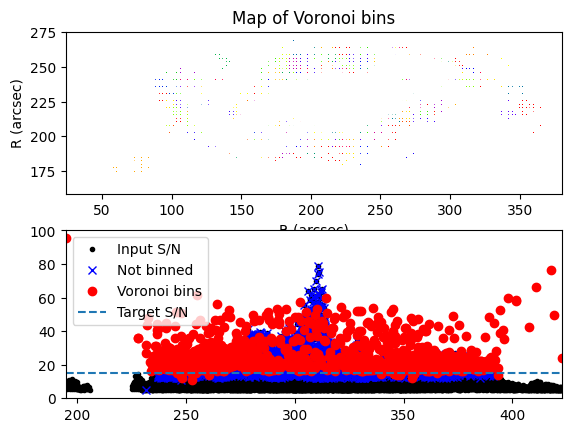

In [24]:
binNum, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning(x, y, signal[x,y], noise[x,y], 15, plot=1, quiet=1,pixelsize=0.2)

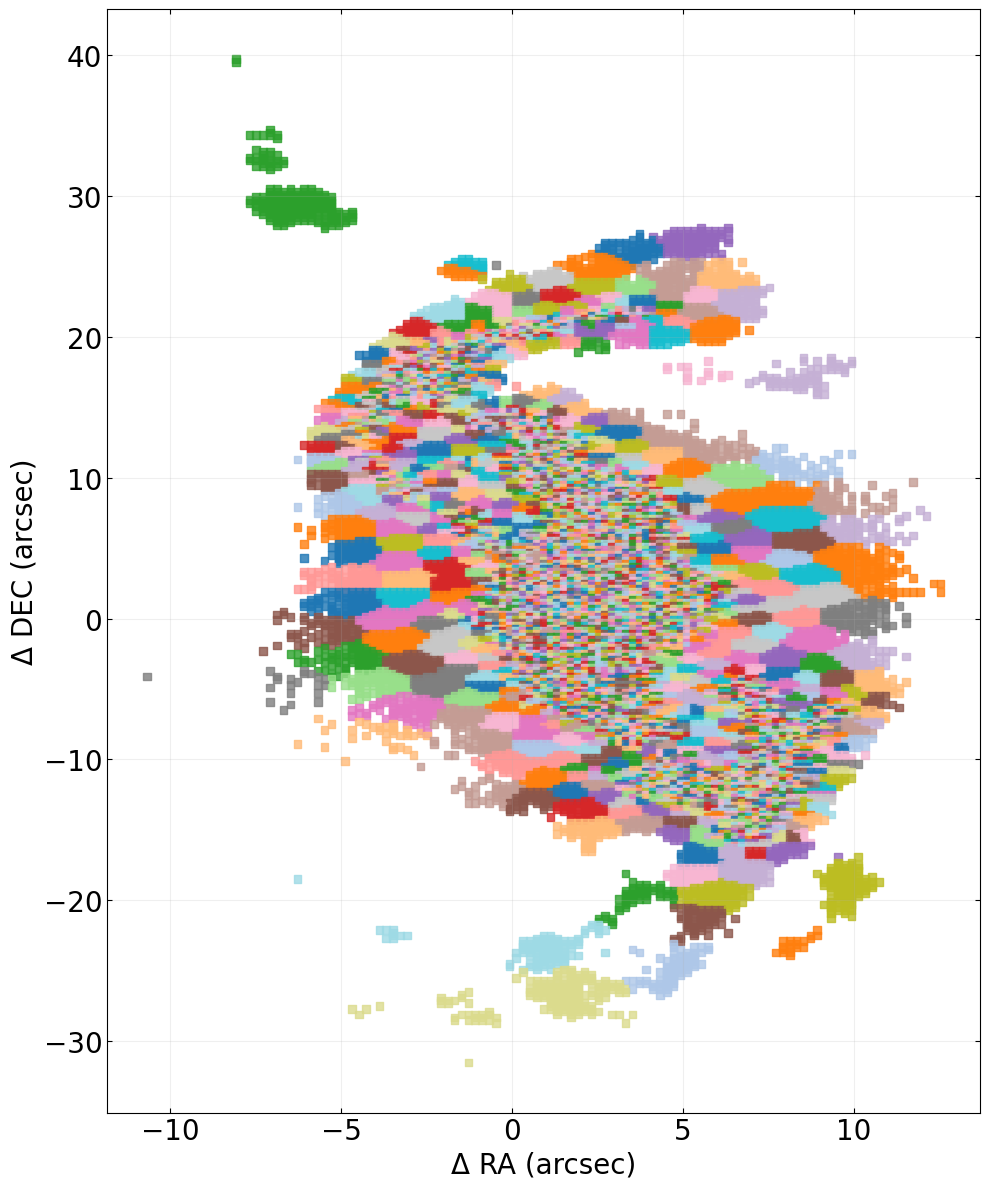

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

plt.figure(figsize=(10, 12)) 


np.random.seed(42)  
unique_bins = np.unique(binNum)
color_mapping = np.random.permutation(len(unique_bins))
bin_to_color = {bin_id: color_mapping[i] for i, bin_id in enumerate(unique_bins)}
mixed_colors = np.array([bin_to_color[bin_id] for bin_id in binNum])


plt.scatter(delta_dec_arcsec, delta_ra_arcsec, c=mixed_colors, cmap='tab20', s=30, alpha=0.8, marker="s")
#plt.scatter(y_gen_centered, x_gen_centered, c='b', s=1, alpha=0.9, marker='o', edgecolors='black', linewidth=1)
plt.ylabel('Δ DEC (arcsec)', fontsize=20)
plt.xlabel('Δ RA (arcsec)', fontsize=20)
plt.tick_params(which='both', direction='in', top=True, right=True, 
               bottom=True, left=True, labelsize=10)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.savefig("Teselacion de voronoi")
plt.show()


## Modificacion de mi funcion de calcular flujos para hacerlo con voronoi bins.

Cambio: Tuve que cambiar el .sum(...) que tengo en la funciona a .mean() ya que en el diagrama bpt no me sale nada en SF siendo que esta galaxia si presenta eso

Cambio: Optimice la funcion para que corra todo mucho mas rapido, un 80% mas rapido aprox.

In [27]:
import time

lines = {
    "OIII": (430, 455),
    "Hbeta": (315, 340),
    "NII": (1733, 1750),
    "Halpha": (1719, 1732)
}

lines_1 = {
    "OIII": (430, 455)
}

# Cosas que cambiar
# Primero tenemos que hacer .sum(axis=(1,2)) para tener el 1D, luego podemos hacer lo demas.

def calcular_flux_lum_voronoi(nombres, cube, x, y, BinNum):
    fluxes = {}
    Lum  = {}
    for nombre in nombres:
        channel_x, channel_y = nombres[nombre]
        all_flux_per_bin = []
        all_lum_per_bin = []

        """
        El codigo demora mucho si se hace para TODOS los bins, voy a considerar el hecho de que varios BinNum se repiten y nos saltaremos el
        calculo para estos
        """
        
        bin_anterior = -888
        flux_anterior = 0
        lum_anterior = 0
        cube_copy = cube[channel_x:channel_y, :,:].copy()
        for Bin2use in BinNum:
            
            if bin_anterior != Bin2use:
                
                cube_copy.mask = np.ones_like(cube_copy.mask)*True
                
                cube_copy.mask[:,x[BinNum==Bin2use],y[BinNum==Bin2use]] = np.zeros_like(cube_copy.mask[:,x[BinNum==Bin2use],y[BinNum==Bin2use]])*True

                line = cube_copy.mean(axis=(1,2))
            
                line_continuo = line.poly_spec(1)
                line_sin_cont = line-line_continuo
                
                wave = line.wave.coord()
                flux = simpson(line_sin_cont.data, x=wave) * line_sin_cont.unit * line_sin_cont.wave.unit
                
                z = 0.0297
                dL = cosmo.luminosity_distance(z)
                L = 4*np.pi*dL*dL*(flux).to(u.erg / u.cm**2 / u.s)
    
                all_flux_per_bin.append(flux)
                all_lum_per_bin.append(L)

                bin_anterior = Bin2use
                flux_anterior = flux
                lum_anterior = L
                #print(f"Pase por aca: flux = {flux}, L = {L}, Bin used = {Bin2use}")
            else:
                bin_anterior = Bin2use
                all_flux_per_bin.append(flux_anterior)
                all_lum_per_bin.append(lum_anterior)
        
        fluxes[nombre] = all_flux_per_bin
        Lum[nombre] = all_lum_per_bin

    return fluxes, Lum
t0 = time.time()
#fluxes, Lum = calcular_flux_lum_voronoi(lines_1,cube,x,y,binNum) # No usar demora demasiado.
t1 = time.time() 

print(f"Tiempo total: {t1 - t0:.2f} segundos")

Tiempo total: 0.00 segundos


### Comparacion de tiempos de calcular flux & Lum para OIII
V1, copy dentro del for: 161.45 segundos

V1, copy fuera del for: 107.13 segundos

V2, copy fuera del for: 16.98 segundos 

V2, copy dentro del for: 25.81 segundos 


V2, copy fuera, all lines, SN Voronoi 30: 300 segundos

V2, copy fuera, all lines, SN Voronoi 15: 1277.43 segundos

In [30]:
from astropy.cosmology import WMAP9 as cosmo
from scipy.integrate import simpson
def calcular_flux_lum_voronoi_ver2(nombres, cube, x, y, BinNum):
    fluxes = {}
    Lum  = {}

    z = 0.0297
    dL = cosmo.luminosity_distance(z)

    for nombre in nombres:
        channel_x, channel_y = nombres[nombre]

        # diccionario de resultados por bin único
        resultados_por_bin = {}

        bins_unicos = set(BinNum)
        cube_copy = cube[channel_x:channel_y, :,:].copy()
        for bin_id in bins_unicos:
           

            cube_copy.mask = np.ones_like(cube_copy.mask)*True
                
            cube_copy.mask[:,x[BinNum==bin_id],y[BinNum==bin_id]] = np.zeros_like(cube_copy.mask[:,x[BinNum==bin_id],y[BinNum==bin_id]])*True

            line = cube_copy.mean(axis=(1, 2))
            line_continuo = line.poly_spec(1)
            line_sin_cont = line - line_continuo

            wave = line.wave.coord()
            flux = simpson(line_sin_cont.data, x=wave) * line_sin_cont.unit * line_sin_cont.wave.unit

            L = 4 * np.pi * dL * dL * flux.to(u.erg / u.cm**2 / u.s)

            resultados_por_bin[bin_id] = (flux, L)

        # reconstrucción en orden original de BinNum
        all_flux_per_bin = []
        all_lum_per_bin = []
        for bin_id in BinNum:
            flux, L = resultados_por_bin[bin_id]
            all_flux_per_bin.append(flux)
            all_lum_per_bin.append(L)

        fluxes[nombre] = all_flux_per_bin
        Lum[nombre] = all_lum_per_bin

    return fluxes, Lum


import time

t0 = time.time()
fluxes, Lum = calcular_flux_lum_voronoi_ver2(lines, cube, x, y, binNum)
t1 = time.time()

print(f"Tiempo total: {t1 - t0:.2f} segundos")


Tiempo total: 1277.43 segundos


# Flujos por spaxel individuales, todo el proceso de antes repetido ahora para uno.

Demora aprox 30 minutos en cargar todos los datos

In [ ]:
import numpy as np
from scipy.integrate import simpson
from astropy import units as u
import numpy as np
from scipy.integrate import simpson
from astropy import units as u

def calcular_flujos_luminosidades_spaxel(lines, cube, x, y, cosmo, z=0.0297):
    
    fluxes_result = {}
    luminosities_result = {}

    z = 0.0297
    dL = cosmo.luminosity_distance(z)
    
    for line_name, (start, stop) in lines.items():
        cube_line = cube[start:stop, :, :]
        flujos = []
        luminosidades = []
        for xi, yi in zip(x, y):
            line = cube_line[:, xi, yi]
            
            wave = line.wave.coord()  
            line_continuo = line.poly_spec(1)
            line_sin_cont = line - line_continuo

            wave = line.wave.coord()
            flux = simpson(line_sin_cont.data, x=wave) * line_sin_cont.unit * line_sin_cont.wave.unit
            L = 4 * np.pi * dL**2 * flux.to(u.erg / u.cm**2 / u.s)

            flujos.append(flux)
            luminosidades.append(L)

        fluxes_result[line_name] = flujos
        luminosities_result[line_name] = luminosidades

    return fluxes_result, luminosities_result



# Ahora fluxes_spaxel["Hbeta"][i] corresponde exactamente a fluxes_spaxel["OIII"][i] para el mismo spaxel



In [31]:
# lines ya definido, por ejemplo:
lines = {
    "OIII": (430, 455),
    "Hbeta": (315, 340),
    "NII": (1733, 1750),
    "Halpha": (1719, 1732)
}


#error_dict = {}

#for line_name, (start, stop) in lines.items():
    # calcula el error como raíz de la varianza en el eje espectral
#    error = np.sqrt(np.argmax(cube[start:stop, :, :].var, axis=0))
#    error[error==0] = np.nan
#    error_dict[line_name] = error
    

In [ ]:
import numpy as np

# Elige los spaxel optimos para cada linea y despues crea una mask global

SN_min = 8
mask_dict = {}

for line_name, (start, stop) in lines.items():
    cube_line = cube[start:stop, :, :]
    noise = error_dict[line_name]
    
    # señal máxima por spaxel
    signal = cube_line.max(axis=0).data
    
    # crear máscara de validez: descartar NaN o masked
    valid = np.isfinite(signal) & np.isfinite(noise)  # True solo si ambos son finitos
    
    # máscara S/N solo para valores válidos
    mask_sn = np.zeros_like(signal, dtype=bool)
    mask_sn[valid] = (signal[valid] / noise[valid] > SN_min)
    
    mask_dict[line_name] = mask_sn

# máscara común combinando todas las líneas
mask_comun = np.logical_and.reduce(list(mask_dict.values()))

# extraer spaxels válidos
x, y = np.nonzero(mask_comun)




In [ ]:
#fluxes_spaxel, luminosities_spaxel = calcular_flujos_luminosidades_spaxel(
#    lines=lines,
#    cube=cube,
#    x=x,
#    y=y,
#    cosmo=cosmo,
#    z=0.0297
#)

# Ahora:
# fluxes_spaxel["Hbeta"][i] y luminosities_spaxel["Hbeta"][i] corresponden al mismo spaxel
# que fluxes_spaxel["OIII"][i] y luminosities_spaxel["OIII"][i], etc.


## Agregamos la correccion por extincion al polvo

In [32]:
import numpy as np
from extinction import calzetti00, remove

def calcular_factores_extincion(Lum):
    """
    Calcula los factores de corrección por extinción para Halpha y Hbeta
    a partir de las luminosidades observadas.

    """
    factor_Ha_list = []
    factor_Hb_list = []

    # Longitudes de onda de Halpha y Hbeta en Angstrom
    wave_Ha = np.array([6563.0])
    wave_Hb = np.array([4861.0])
    
    for Ha_obs, Hb_obs in zip(Lum["Halpha"], Lum["Hbeta"]):
        # 1. Calcular razón observada Halpha/Hbeta
        ObservedHa_Hb = Ha_obs / Hb_obs

        # 2. Calcular E(B-V)
        EB_V = (2.5 / (calzetti00(wave_Hb, 1, 1) - calzetti00(wave_Ha, 1, 1))) * np.log10(ObservedHa_Hb / 2.86)

        # 3. Calcular factores de corrección
        factor_Ha = remove(calzetti00(wave_Ha, EB_V, 1), [1])[0]
        factor_Hb = remove(calzetti00(wave_Hb, EB_V, 1), [1])[0]

        factor_Ha_list.append(factor_Ha)
        factor_Hb_list.append(factor_Hb)
    
    return factor_Ha_list, factor_Hb_list


factor_Ha_list, factor_Hb_list = calcular_factores_extincion(Lum)



C:\Users\Maxlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\astropy\units\quantity.py:659: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


C:\Users\Maxlo\AppData\Local\Temp\ipykernel_34660\3022803689.py:12: RuntimeWarning: invalid value encountered in log10
  decremento_balmer = np.log10(decremento_balmer + eps)


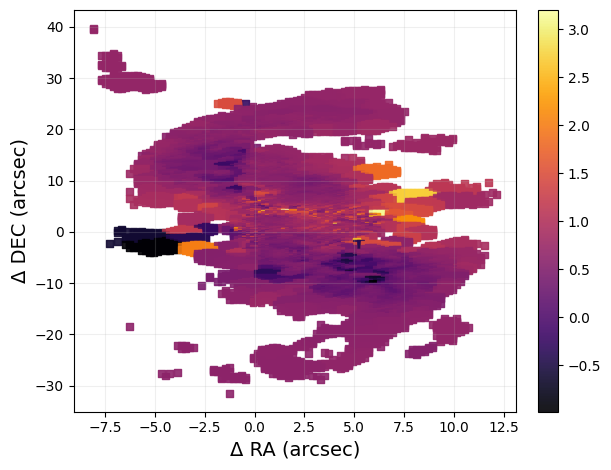

Decremento mínimo: -0.98
Decremento máximo: 3.20
Decremento medio: 0.63


In [33]:
import matplotlib.pyplot as plt
from matplotlib import colors
def plot_decremento_balmer(xc, yc, Lum, rango=60, cmap='inferno', s=25, log_scale=True):

    decremento_balmer = [Ha/Hb for Ha,Hb in zip(Lum["Halpha"], Lum["Hbeta"])]
    decremento_balmer = np.array(decremento_balmer, dtype=float)


    if log_scale:
        eps = 1e-10
        decremento_balmer = np.ma.masked_less_equal(decremento_balmer, 0)
        decremento_balmer = np.log10(decremento_balmer + eps)


    gamma = 1
    norm = colors.PowerNorm(gamma=gamma, 
                            vmin=np.min(decremento_balmer), 
                            vmax=np.max(decremento_balmer))


    plt.scatter(delta_dec_arcsec, delta_ra_arcsec, c=decremento_balmer, cmap=cmap, s=s, marker='s', 
                alpha=0.9, norm=norm, zorder=1)

    plt.xlabel('arcsec', fontsize=15)
    plt.ylabel('arcsec', fontsize=15)
    

    plt.grid(True, alpha=0.2)

    cbar = plt.colorbar(orientation='vertical', pad=0.04)

    plt.ylabel('Δ DEC (arcsec)', fontsize=14)

    plt.xlabel('Δ RA (arcsec)', fontsize=14)
    plt.tight_layout()
    plt.savefig("Decremento de balmer")
    plt.show()

plot_decremento_balmer(x, y, Lum, rango=60,s=25)


In [ ]:
#razon_Ha_Hb_corregida = [
#    (Ha * fHa) / (Hb * fHb) 
#    for Ha, Hb, fHa, fHb in zip(luminosities_spaxel["Halpha"], luminosities_spaxel["Hbeta"], factor_Ha_list, factor_Hb_list)
#]
#
#
#print("Primeras 5 razones Halpha/Hbeta corregidas:", razon_Ha_Hb_corregida[:5])



In [ ]:
razon_Ha_Hb_corregida = [
    (Ha * fHa) / (Hb * fHb) 
    for Ha, Hb, fHa, fHb in zip(Lum["Halpha"], Lum["Hbeta"], factor_Ha_list, factor_Hb_list)
]



In [ ]:
#razones_OIII_Hbeta = [(x/y) for x, y in zip(fluxes_spaxel["OIII"], fluxes_spaxel["Hbeta"])]
#
#razones_NII_Halpha = [(x/y) for x, y in zip(fluxes_spaxel["NII"], fluxes_spaxel["Halpha"])]

In [36]:
razones_OIII_Hbeta = [(x/y) for x, y in zip(fluxes["OIII"], fluxes["Hbeta"])]
razones_NII_Halpha = [(x/y) for x, y in zip(fluxes["NII"], fluxes["Halpha"])]




C:\Users\Maxlo\AppData\Local\Temp\ipykernel_34660\4139278757.py:18: RuntimeWarning: invalid value encountered in log10
  razon = np.log10(razon + eps)


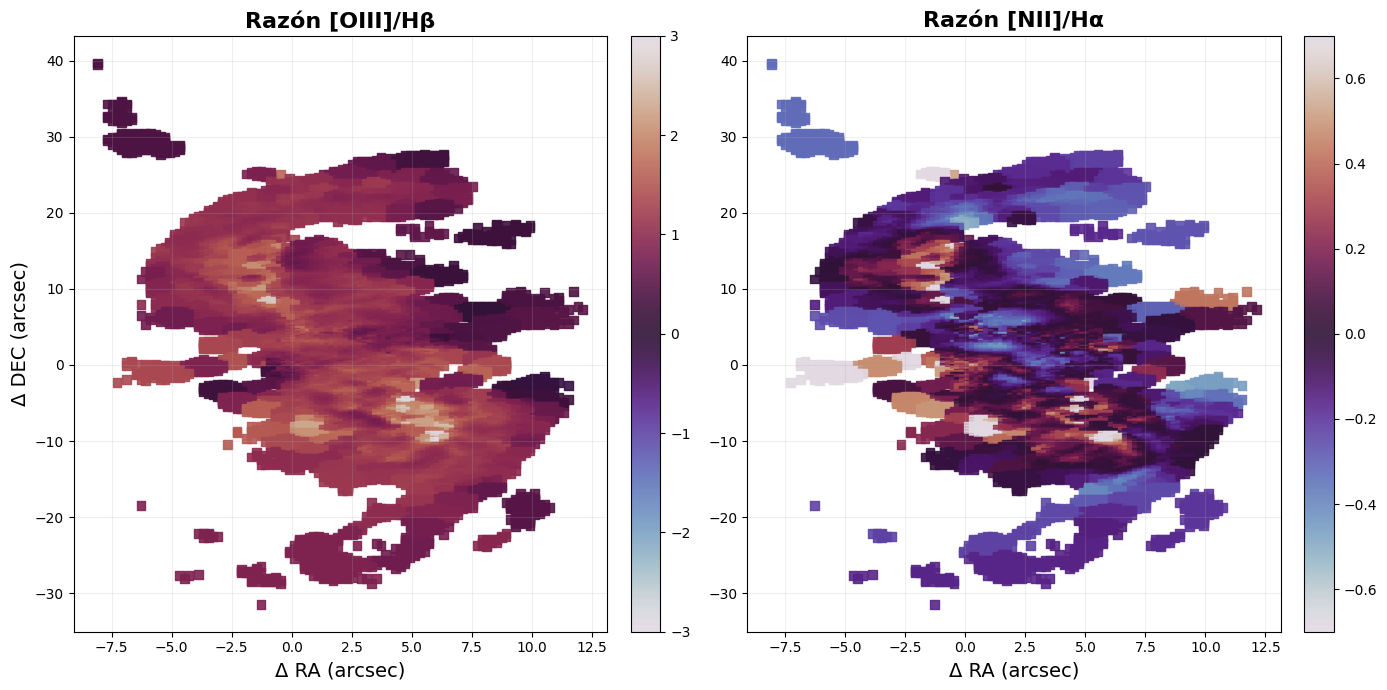

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_razones_lado_lado(xc, yc, binNum, razon1, razon2, titulo1, titulo2,
                            cmap='twilight', s=40, gamma=1, log_scale=True):
    """
    Grafica dos razones de flujo lado a lado en la misma figura.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14,7))  

    for ax, razon, titulo in zip(axes, [razon1, razon2], [titulo1, titulo2]):

        if log_scale:
            eps = 1e-10
            razon = np.array(razon, dtype=float)
            razon = np.ma.masked_less_equal(razon, 0)
            razon = np.log10(razon + eps)


        if titulo == "Razón [NII]/Hα":
            norm = colors.TwoSlopeNorm(vmin=-0.7, vcenter=0, vmax=0.7)
        else:
            norm = colors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)

        
        sc = ax.scatter(delta_dec_arcsec, delta_ra_arcsec, c=razon, cmap=cmap, 
                        s=s, marker='s', alpha=0.9, norm=norm, zorder=1)
        

        if titulo == "Razón [NII]/Hα":
            pass
        else:
            ax.set_ylabel('Δ DEC (arcsec)', fontsize=14)

        ax.set_xlabel('Δ RA (arcsec)', fontsize=14)
        ax.grid(True, alpha=0.2)
        ax.set_title(titulo, fontsize=16, fontweight='bold')
        cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.056, pad=0.04)
    
    plt.tight_layout()
    plt.savefig("Razones de flujo scatter")
    plt.show()



Halpha_corr_list = [Ha * fHa for Ha, fHa in zip(fluxes["Halpha"], factor_Ha_list)]
Hbeta_corr_list  = [Hb * fHb for Hb, fHb in zip(fluxes["Hbeta"], factor_Hb_list)]

# Razón OIII / Hβ usando Hβ corregido
OIII_Hb_corr = [OIII / Hb_corr for OIII, Hb_corr in zip(fluxes["OIII"], Hbeta_corr_list)]

# Razón NII / Hα usando Hα corregido
NII_Ha_corr = [NII / Ha_corr for NII, Ha_corr in zip(fluxes["NII"], Halpha_corr_list)]

plot_razones_lado_lado(x, y, binNum, 
                       OIII_Hb_corr, NII_Ha_corr, 
                       'Razón [OIII]/Hβ', 'Razón [NII]/Hα',
                       gamma=1, log_scale=True)


# Intento rustico de hacer la comparacion de flujos. Pero fracase, tengo dudas, no se si hacerlo para un spaxel en especfico o para todos. Fracase

# Comparacion de Luminosidades y Extincion por polvo.
Primero sacare la de $H_\alpha$ y $H_\beta$ en caso que sea cercano a un valor de 2.86 entonces esta bien, sino necesita correccion por extincion de polvo.

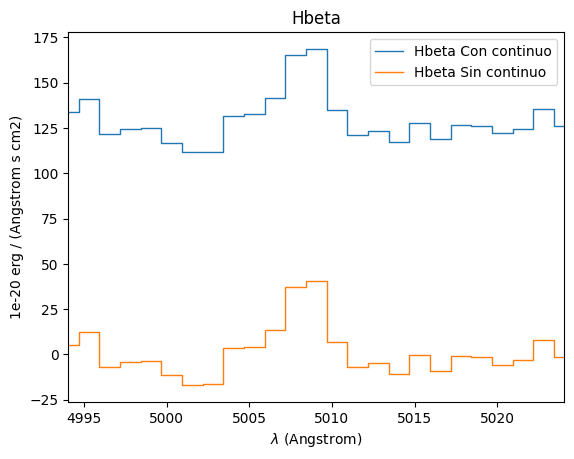

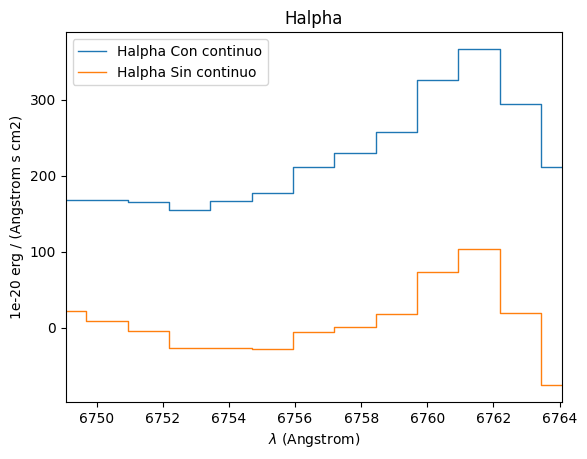

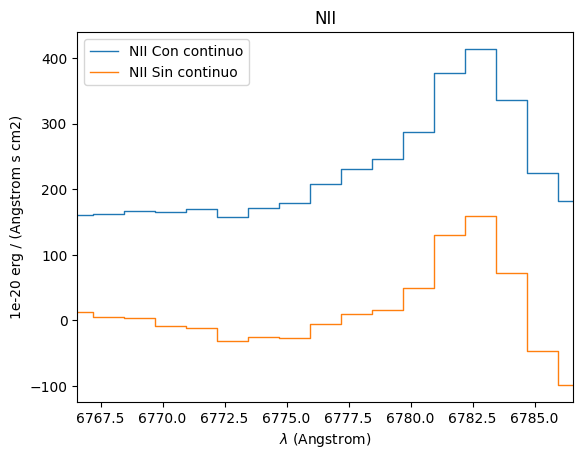

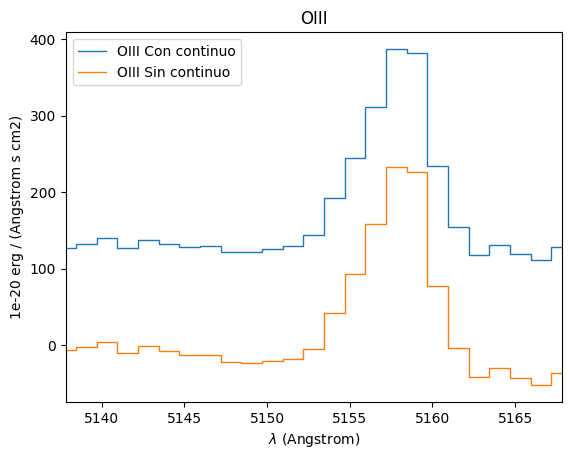

{'Hbeta': <Quantity 43.20303194 1e-20 erg / (s cm2)>, 'Halpha': <Quantity 128.0193919 1e-20 erg / (s cm2)>, 'NII': <Quantity 297.45388418 1e-20 erg / (s cm2)>, 'OIII': <Quantity 645.35523784 1e-20 erg / (s cm2)>} {'Hbeta': (<Quantity 8.92652829e+35 erg / s>, <Quantity 233.19039431 solLum>), 'Halpha': (<Quantity 2.64511233e+36 erg / s>, <Quantity 690.99068126 solLum>), 'NII': (<Quantity 6.14593558e+36 erg / s>, <Quantity 1605.52131232 solLum>), 'OIII': (<Quantity 1.33342072e+37 erg / s>, <Quantity 3483.3352108 solLum>)}
2.96320388026786
[2.86]


In [80]:
from scipy.integrate import simpson

lines = {
    "OIII": (430, 455),
    "Hbeta": (315, 340),
    "NII": (1733, 1750),
    "Halpha": (1719, 1732)
}

def calcular_lum(nombres, cube):
    fluxes = {}
    Lum  = {}
    for nombre in nombres:
        channel_x, channel_y = lines[nombre]
        line = cube[channel_x:channel_y, 224,215]
        line.plot(label=f"{nombre} Con continuo",title=nombre)
            
        line_continuo = line.poly_spec(1)
        line_sin_cont = line-line_continuo
        
        line_sin_cont.plot(label=f"{nombre} Sin continuo")
        plt.legend()
        plt.show()
        wave = line.wave.coord()
        flux = simpson(line_sin_cont.data, x=wave) * line_sin_cont.unit * line_sin_cont.wave.unit
        fluxes[nombre] = flux

        z = 0.0297
        dL = cosmo.luminosity_distance(z)
        L = 4*np.pi*dL*dL*(flux).to(u.erg / u.cm**2 / u.s)
        Lum[nombre] = (L.to(u.erg/u.s),L.to(u.Lsun))

    return fluxes, Lum

Fluxes, Luminosidades = calcular_lum(["Hbeta", "Halpha","NII","OIII"],cube)

print(Fluxes, Luminosidades)

Razon_de_lum = Luminosidades["Halpha"][1]/(Luminosidades['Hbeta'][1])
print(Razon_de_lum)

import numpy as np
import extinction

#https://iopscience.iop.org/article/10.1088/0004-637X/763/2/145/pdf

ObservedHa_Hb = Razon_de_lum
 #Razon medida de Halpha sobre Hbeta. Notar que son Luminosidades. 

#Esto compara la razón de luminosidad con la razón teorica de 2.86 y lo compara con la curva de extinción de ccm89 para las longitudes de onda de Ha y Hb
EB_V = (2.5/(extinction.calzetti00(np.array([4861.0]), 1, 1)-extinction.calzetti00(np.array([6563.0]), 1, 1)))*np.log10(ObservedHa_Hb/2.86)

#Esta función calcula los factores de correción para una longitud de onda dada usando el EB_V calculado arriba. 
# Esta función devuelve un factor, digamos 1.2x. Entonces el flujo corregido es el flujo observado multiplicado por 1.2. 
extinction.remove(extinction.calzetti00(np.array([6563.0]), EB_V, 1), [1])
factor_Ha = extinction.remove(extinction.calzetti00(np.array([6563.0]), EB_V, 1), [1])
factor_Hb = extinction.remove(extinction.calzetti00(np.array([4861.0]), EB_V, 1), [1])

Razon_de_lum_1 = Luminosidades["Halpha"][1]*factor_Ha/(Luminosidades['Hbeta'][1]*factor_Hb)
print(Razon_de_lum_1)

# Diagrama BPT

In [37]:
import numpy as np

# Supongamos que ya calculaste las razones
# razones_OIII_Hbeta y razones_NII_Halpha son listas o arrays
mask = (np.array(razones_OIII_Hbeta) > 0) & (np.array(razones_NII_Halpha) > 0)
log_OIII_Hb = np.log10(np.array(razones_OIII_Hbeta)[mask])
log_NII_Ha  = np.log10(np.array(razones_NII_Halpha)[mask])


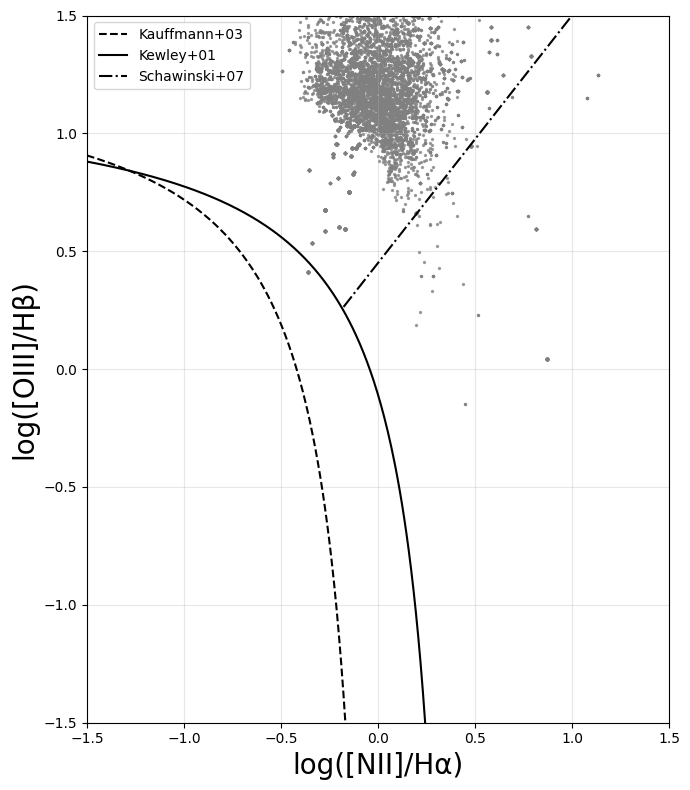

In [38]:
import matplotlib.pyplot as plt


x_vals = np.linspace(-1.5, 1.5, 500)

# Curvas teóricas
kauffmann = 0.61 / (x_vals - 0.05) + 1.3
kewley    = 0.61 / (x_vals - 0.47) + 1.19
schawinski = 1.05 * x_vals + 0.45


plt.figure(figsize=(7,8))


plt.scatter(log_NII_Ha, log_OIII_Hb, c='gray', s=2, alpha=0.7)


plt.plot(x_vals[:-250], kauffmann[:-250], 'k--', label='Kauffmann+03')
plt.plot(x_vals[:-200], kewley[:-200], 'k-', label='Kewley+01')
plt.plot(x_vals[220:], schawinski[220:], 'k-.', label='Schawinski+07')


plt.xlabel('log([NII]/Hα)', fontsize = 20)
plt.ylabel('log([OIII]/Hβ)', fontsize = 20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.tight_layout()
plt.show()


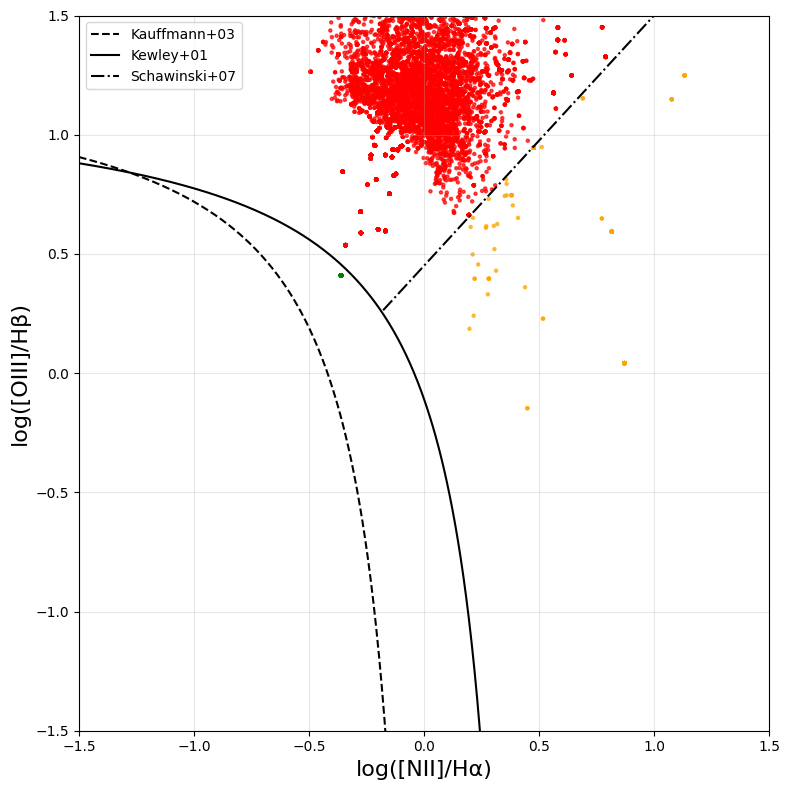

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


x_vals = np.linspace(-1.5, 1.5, 500)


x_kauf = x_vals[x_vals != 0.05]
y_kauf = 0.61 / (x_kauf - 0.05) + 1.3

x_kew = x_vals[x_vals != 0.47]
y_kew = 0.61 / (x_kew - 0.47) + 1.19

x_sch = x_vals
y_sch = 1.05*x_sch + 0.45


kauffmann_interp = interp1d(x_kauf, y_kauf, bounds_error=False, fill_value='extrapolate')
kewley_interp    = interp1d(x_kew, y_kew, bounds_error=False, fill_value='extrapolate')
schawinski_interp= interp1d(x_sch, y_sch, bounds_error=False, fill_value='extrapolate')

colors = []
for xi, yi in zip(log_NII_Ha, log_OIII_Hb):
    y_kauf_val = kauffmann_interp(xi)
    y_kewl_val = kewley_interp(xi)
    y_schaw_val= schawinski_interp(xi)

    # Star-Forming (azul)
    if yi < y_kauf_val and xi < 0:
        colors.append('blue')
    # Compuesto (verde)
    elif y_kauf_val <= yi < y_kewl_val:
        colors.append('green')
    # AGN
    elif yi >= y_kewl_val and xi <0.47:
        if yi > y_schaw_val:
            colors.append('red')    # Seyfert
        else:
            colors.append('orange') # LINER
    elif yi <= y_kewl_val and xi >=0.47:
        if yi > y_schaw_val:
            colors.append('red')    # Seyfert
        else:
            colors.append('orange') # LINER
    else:
        colors.append('gray')


plt.figure(figsize=(8,8))
plt.scatter(log_NII_Ha, log_OIII_Hb, c=colors, s=5, alpha=0.7)

plt.plot(x_kauf[:-250], y_kauf[:-250], 'k--', label='Kauffmann+03')
plt.plot(x_kew[:-200], y_kew[:-200], 'k-', label='Kewley+01')
plt.plot(x_sch[220:], y_sch[220:], 'k-.', label='Schawinski+07')

plt.xlabel('log([NII]/Hα)', fontsize=16)
plt.ylabel('log([OIII]/Hβ)', fontsize=16)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Diagrama bpt")
plt.show()


## Usamos tambien razones corregidas de H_alpha y Hbeta por si acaso.

In [40]:
Halpha_corr_list = [Ha * fHa for Ha, fHa in zip(fluxes["Halpha"], factor_Ha_list)]
Hbeta_corr_list  = [Hb * fHb for Hb, fHb in zip(fluxes["Hbeta"], factor_Hb_list)]

# Razón OIII / Hβ usando Hβ corregido
OIII_Hb_corr = [OIII / Hb_corr for OIII, Hb_corr in zip(fluxes["OIII"], Hbeta_corr_list)]

# Razón NII / Hα usando Hα corregido
NII_Ha_corr = [NII / Ha_corr for NII, Ha_corr in zip(fluxes["NII"], Halpha_corr_list)]

In [41]:
OIII_Hb_corr = np.array(OIII_Hb_corr)
NII_Ha_corr  = np.array(NII_Ha_corr)

mask = (OIII_Hb_corr > 0) & (NII_Ha_corr > 0)

log_OIII_Hb = np.log10(OIII_Hb_corr[mask])
log_NII_Ha  = np.log10(NII_Ha_corr[mask])


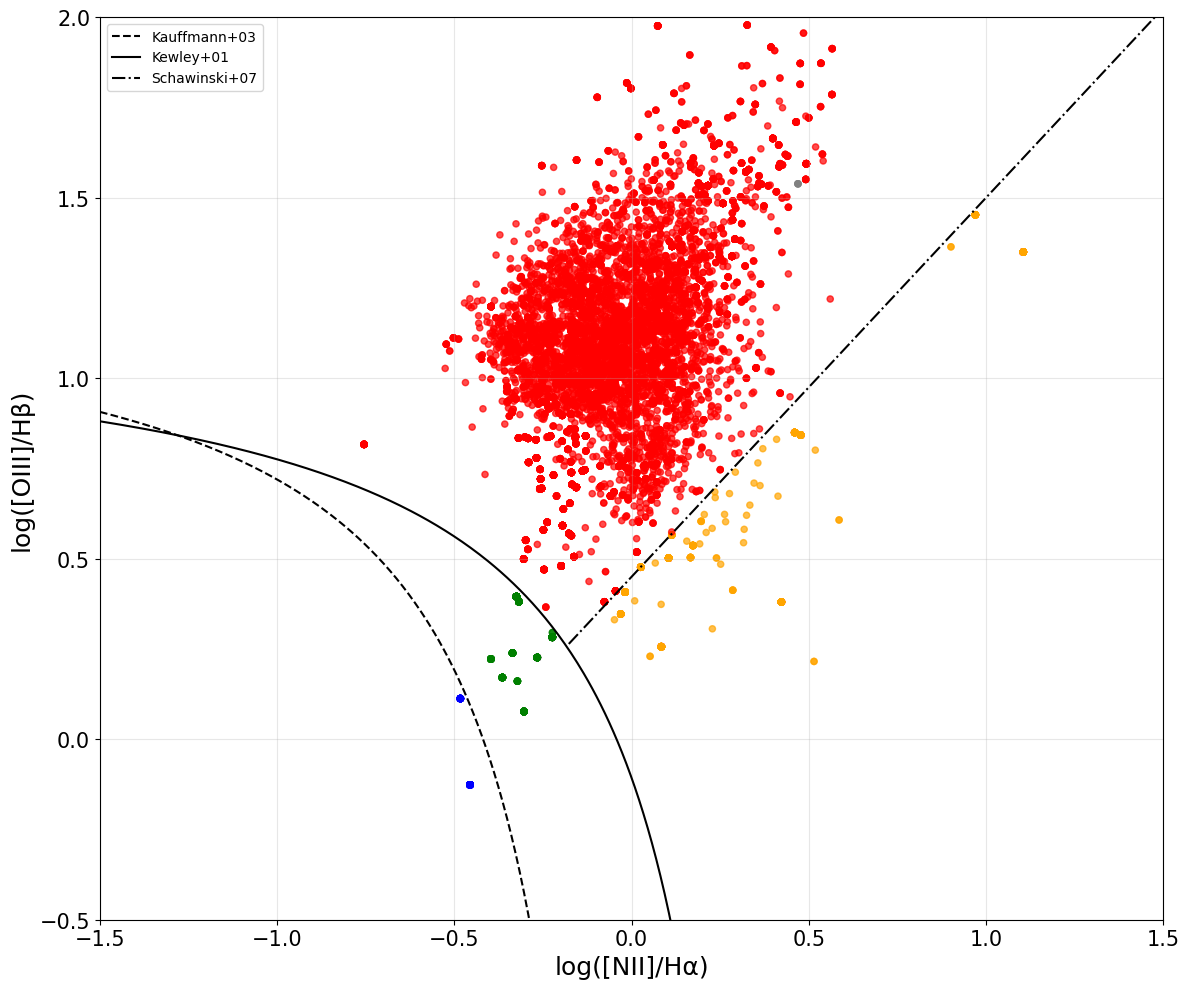

In [78]:
import matplotlib.pyplot as plt

# Valores para curvas teóricas
x_vals = np.linspace(-1.5, 1.5, 500)
kauffmann = 0.61/(x_vals - 0.05) + 1.3
kewley    = 0.61/(x_vals - 0.47) + 1.19
schawinski = 1.05 * x_vals + 0.45


plt.figure(figsize=(12,10))


plt.scatter(log_NII_Ha, log_OIII_Hb, c=colors, s=20, alpha=0.7)


plt.plot(x_vals[:-250], kauffmann[:-250], 'k--', label='Kauffmann+03')
plt.plot(x_vals[:-200], kewley[:-200], 'k-', label='Kewley+01')
plt.plot(x_vals[220:], schawinski[220:], 'k-.', label='Schawinski+07')


plt.xlabel('log([NII]/Hα)', fontsize=18)
plt.ylabel('log([OIII]/Hβ)', fontsize=18)
plt.legend()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, alpha=0.3)
plt.xlim(-1.5, 1.5)
plt.ylim(-0.5, 2)
plt.tight_layout()
plt.savefig("Diagrama_bpt")
plt.show()


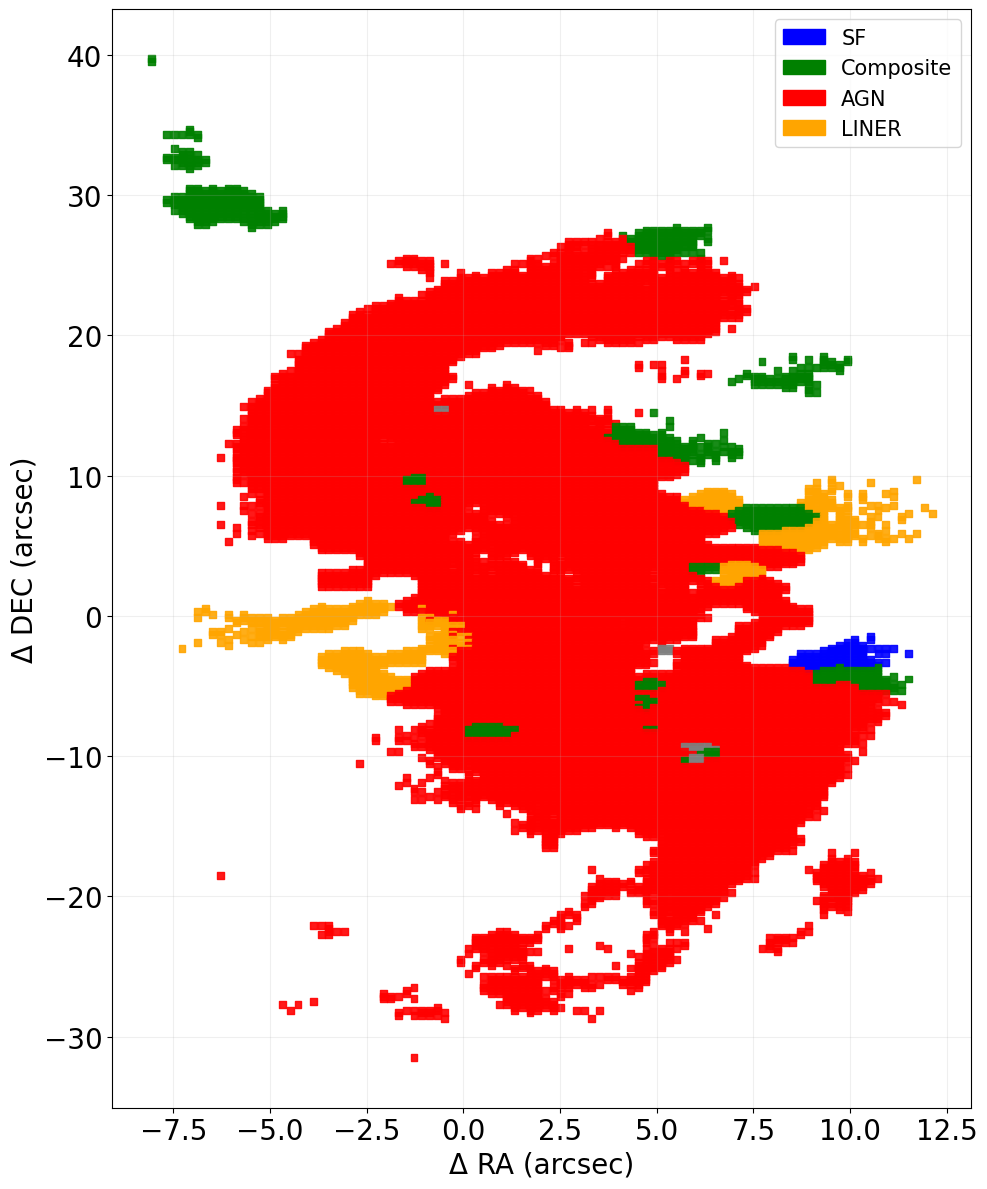

In [70]:
# Convertir a arrays
color_map = {
    'SF': 'green',
    'Composite': 'orange',
    'Seyfert': 'red',
    'LINER': 'purple',
    'AGN': 'blue'
}

OIII_Hb_corr = np.array(OIII_Hb_corr)
NII_Ha_corr  = np.array(NII_Ha_corr)

# Crear mask de spaxels válidos
mask = (OIII_Hb_corr > 0) & (NII_Ha_corr > 0)


log_OIII_Hb = np.log10(OIII_Hb_corr[mask])
log_NII_Ha  = np.log10(NII_Ha_corr[mask])


colors = []
for xi, yi in zip(log_NII_Ha, log_OIII_Hb):
    y_kauf_val = kauffmann_interp(xi)
    y_kewl_val = kewley_interp(xi)
    y_schaw_val= schawinski_interp(xi)

    # Star-Forming (azul)
    if yi < y_kauf_val and xi < 0:
        colors.append('blue')
    # Compuesto (verde)
    elif y_kauf_val <= yi < y_kewl_val:
        colors.append('green')
    # AGN
    elif yi >= y_kewl_val and xi <0.47:
        if yi > y_schaw_val:
            colors.append('red')    # Seyfert
        else:
            colors.append('orange') # LINER
    elif yi <= y_kewl_val and xi >=0.47:
        if yi > y_schaw_val:
            colors.append('red')    # Seyfert
        else:
            colors.append('orange') # LINER
    else:
        colors.append('gray')

import matplotlib.patches as mpatches


color_map = {
    'SF': 'blue',       
    'Composite':"green", # naranja
    'AGN':    'red' ,    # rojo
    "LINER": "orange"}



plt.figure(figsize=(10,12))
plt.scatter(delta_dec_arcsec[mask], delta_ra_arcsec[mask], c=colors, s=25, marker='s', alpha=0.9)
plt.xlabel('arcsec', fontsize=15)
plt.ylabel('arcsec', fontsize=15)
plt.grid(True, alpha=0.2)

patches = [mpatches.Patch(color=v, label=k) for k,v in color_map.items()]
plt.legend(handles=patches, loc='upper right',fontsize=15)

plt.ylabel('Δ DEC (arcsec)', fontsize=20)
plt.xlabel('Δ RA (arcsec)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("Clasificacion bpt espacial")
plt.show()
